# Twitter context predictions 
This competition is to filter tweets that are about natural disasters. 

In [2]:
import pandas as pd

train=pd.read_csv('../input/nlp-getting-started/train.csv')

# EDA

- missing values need to be dealt with
- binary classification 
- target value proportion won't be a problem 

In [3]:
print('Number of tweets:', len(train))
print('Proportion of "keyword" column missing data',round(train.keyword.isnull().sum()/len(train),2),'%' )
print('Proportion of "location" column missing data',round(train.location.isnull().sum()/len(train),2),'%' )
print('Unique target values:', train.target.unique())
print('Proportion of target value = 1', round(len(train[train.target==1])/len(train),2),'%')

Number of tweets: 7613
Proportion of "keyword" column missing data 0.01 %
Proportion of "location" column missing data 0.33 %
Unique target values: [1 0]
Proportion of target value = 1 0.43 %


# Cleaning the text

In [4]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [5]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def tweet_cleaner(text):                          # removing hashtag, mentions with '@', retweets, hyperlinks, and punctuations
    text=re.sub('#','', text)
    text=re.sub('@[A-Za-z0-9]+','', text)
    text=re.sub('RT[\s]+', '', text)
    text=re.sub('https?:\/\/\S+', '', text)
    text=re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]',' ', text)
    text=re.sub(' +', ' ', text)
    return text

stop = set(stopwords.words("english"))
def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
train['text']=train.text.map(remove_stopwords)
train['text']=train.text.map(tweet_cleaner)
train['text']

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       13 000 people receive wildfires evacuation ord...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609     ahrary control wild fires california even nor...
7610                  m1 94 01 04 utc 5km volcano hawaii 
7611    police investigating e bike collided car littl...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

# Count unique words

In [7]:
from collections import Counter

def word_counter(text):
    count=Counter()
    for tweet in text.values:
        for word in tweet.split():
            count[word] += 1
    return count
counter = word_counter(train.text)
print('number of unique words:', len(counter))

number of unique words: 15312


# Splitting into training and validation

In [9]:
X=train.text
y=train.target

# Tokenizer

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=len(counter))
tokenizer.fit_on_texts(X)

train_sequences=tokenizer.texts_to_sequences(X)

from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 15
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")

In [12]:
word_index = tokenizer.word_index
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

decoded_text = decode(train_sequences[10])

print(train_sequences[10])
print(decoded_text)

[484, 11, 554, 200, 394, 555]
three people died heat wave far


In [13]:
import keras
from tensorflow.keras import layers

model = keras.models.Sequential()
model.add(layers.Embedding(len(counter), 32, input_length=15))
model.add(layers.LSTM(64, dropout=0.1))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 32)            489984    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 514,881
Trainable params: 514,881
Non-trainable params: 0
_________________________________________________________________


In [14]:
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model.compile(loss=loss, optimizer=optim, metrics=metrics)

In [22]:
history = model.fit(train_padded, y, epochs=40, validation_split=.10, verbose=0)

# Overfitting is happening immediately

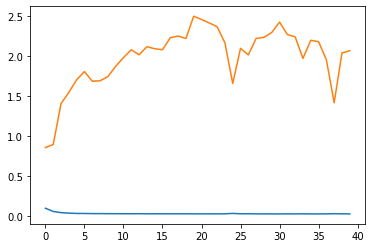

In [24]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

# Retrain
- only one epoch with all the data

In [27]:
model.fit(train_padded, y, epochs=1)

238/238 [==============================] - 2s 9ms/step - loss: 0.1159 - accuracy: 0.9586


# Prediction sample

In [52]:
sample=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
sample

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


# Preparing Test Data and submission 

In [58]:
test=pd.read_csv('../input/nlp-getting-started/test.csv')

test['text']=test.text.map(remove_stopwords)
test['text']=test.text.map(tweet_cleaner)

test_counter = word_counter(train.text)

X_test=test.text

test_sequences=tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")

predictions=model.predict(test_padded)
predictions=[1 if p > .5 else 0 for p in predictions]
predictions=pd.Series(predictions, name='target')
ident=pd.Series(test.id, name='id')
submission=pd.concat([ident, predictions], axis=1)
submission.to_csv("twitter_disaster.csv",index=False)

# Results 

This model got 75% accuracy on the test set. 